In [1]:
import numpy as np
import healpy as hp



In [2]:
# Produce randoms for galaxies or voids
def makeRandom(X, N, R=None, nside=128, seed=1, Nbins_nz=20): # X is RA,Dec,Z from original catalog, N is size of output catalog, R is void radii from input catalog
    npix = hp.nside2npix(nside) # Define mask
    mask = np.zeros((npix), dtype=bool)
    pix = hp.ang2pix(nside, np.pi/2.-X[:,1], X[:,0])
    mask[pix] = True
    skyfrac = 1.*len(mask[mask>0])/len(mask)

    np.random.seed(seed) # Unique seed
    Xr = np.random.rand(int(N*len(X)/skyfrac),3).astype(np.float32) # Draw 3D random catalog and format to RA,Dec,Z
    Xr[:,0] *= 2*np.pi # RA
    Xr[:,1] = np.arccos(1.-2*Xr[:,1]) # Dec
    Xr[:,2] = Xr[:,2]*(X[:,2].max()-X[:,2].min()) + X[:,2].min() # Z

    (n,z) = np.histogram(X[:,2], bins=Nbins_nz) # Calculate n(z) from catalog
    nr = np.interp(Xr[:,2],(z[:-1]+z[1:])/2.,n) # Interpolate n(z) for randoms
    Xr[:,2] = np.random.choice(Xr[:,2],int(N*len(X)/skyfrac),p=nr/np.sum(nr)) # Draw a random realization from that n(z)

    pixr = hp.ang2pix(nside, Xr[:,1], Xr[:,0]) # Masked pixels
    Xr = Xr[mask[pixr],:] # Apply mask
    Xr[:,1] = np.pi/2. - Xr[:,1]

    if R is not None: # Define random void radii
        Rr = np.random.rand(len(Xr)).astype(np.float32) # Draw random void radii
        Rr = Rr*(R.max()-R.min()) + R.min()
        (n,r) = np.histogram(R, bins=Nbins_nz) # Calculate n(rv) from void catalog
        nr = np.interp(Rr,(r[:-1]+r[1:])/2.,n) # Interpolate n(rv) for randoms
        Rr = np.random.choice(Rr,len(Xr),p=nr/np.sum(nr)) # Draw a random realization from that n(rv)
        return Xr,Rr
    else:
        return Xr





In [3]:
fnamev = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/data/untrimmed_sky_positions_central_Redmagic_highdens_y3a2_v0.5.1.out'

dfv = np.loadtxt(fnamev)
void_r_all = dfv[:,3]
rmin, rmax = np.amin(void_r_all), np.amax(void_r_all)
ind_sel = np.where((void_r_all > rmin) & (void_r_all < rmax))[0]
datapoint_z_all, datapoint_ra_all, datapoint_dec_all = dfv[ind_sel,2], dfv[ind_sel,0], dfv[ind_sel,1]
datapoint_weight_all = np.ones_like(datapoint_z_all)
datapoint_radius_all = dfv[ind_sel,3]

X_inp = np.array([datapoint_ra_all*(np.pi/180.), datapoint_dec_all*(np.pi/180.), datapoint_z_all]).T
R_out = makeRandom(X_inp, 30)

R_out[:,0] = R_out[:,0]*(180./np.pi)
R_out[:,1] = R_out[:,1]*(180./np.pi)







In [34]:
R_out.shape




(385473, 3)

In [4]:
def ang2eq(theta, phi):
    ra = phi * 180. / np.pi
    dec = 90. - theta * 180. / np.pi
    return ra, dec


def eq2ang(ra, dec):
    phi = ra * np.pi / 180.
    theta = (np.pi / 2.) - dec * (np.pi / 180.)
    return theta, phi

thetav, phiv = eq2ang(datapoint_ra_all, datapoint_dec_all )



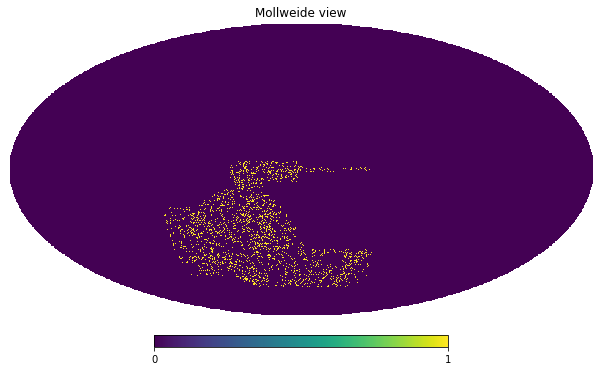

In [5]:
nside = 256
ind_v_all = np.zeros(hp.nside2npix(nside))

indv = hp.ang2pix(nside, thetav, phiv)
ind_v_all[indv] = 1
hp.mollview(ind_v_all)




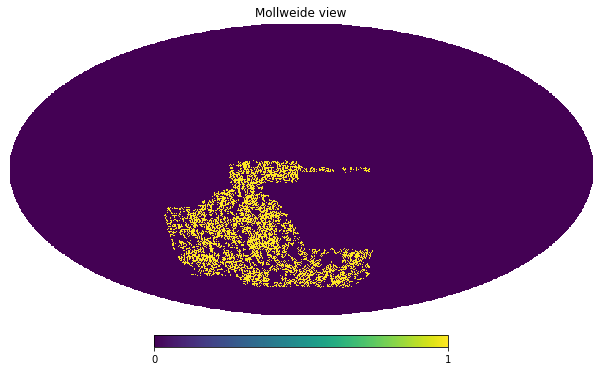

In [6]:
thetar, phir = eq2ang(R_out[:,0],R_out[:,1] )
ind_r_all = np.zeros(hp.nside2npix(nside))

indr = hp.ang2pix(nside, thetar, phir)
ind_r_all[indr] = 1
hp.mollview(ind_r_all)




In [31]:
nstry = 8
ind_r_all = np.zeros(hp.nside2npix(nstry))

indr = hp.ang2pix(nstry, thetar, phir)
ind_r_all[indr] = 1

nside = 1024
mask_input = hp.ud_grade(ind_r_all,nside)


true_y_file = '/global/cfs/cdirs/des/shivamp/actxdes/data_set/planck_data/pl2015/nilc_ymaps.fits'

ymap_truth = hp.read_map(true_y_file)
ymap_truth = hp.ud_grade(ymap_truth,nside)

npix_ymap = len(ymap_truth)
nside_ymap = hp.npix2nside(npix_ymap)
pix_theta, pix_phi = hp.pix2ang(nside_ymap, np.arange(npix_ymap))
pix_ra, pix_dec = ang2eq(pix_theta, pix_phi)

ind_masked = np.where(mask_input < 1e-4)[0]
ind_rand = hp.ang2pix(nside, pix_theta, pix_phi)
int_ind_rand = np.in1d(ind_rand, ind_masked)
selection_mask_rand = np.where(int_ind_rand == False)[0]

pix_ra_m, pix_dec_m = pix_ra[selection_mask_rand], pix_dec[selection_mask_rand]
pix_theta_m, pix_phi_m = pix_theta[selection_mask_rand], pix_phi[selection_mask_rand]

# hp.mollview(ind_r_all)



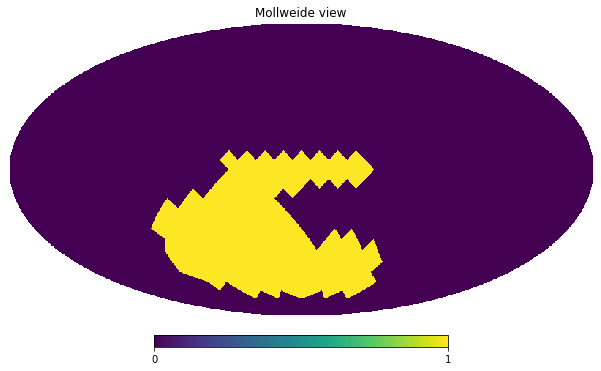

In [32]:
nside = 256
ind_v_all = np.zeros(hp.nside2npix(nside))

indv = hp.ang2pix(nside, pix_theta_m, pix_phi_m)
ind_v_all[indv] = 1
hp.mollview(ind_v_all)





In [8]:
import pickle as pk
df = {'ra':R_out[:,0], 'dec':R_out[:,1], 'z':R_out[:,2]}
pk.dump(df, open('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/process_cats/void_random_cat.pk','wb'))  




In [18]:
import mycosmo as cosmodef
import scipy as sp

def data_coord_cov(ra_in,dec_in, icrs2gal=False, gal2icrs=False):
    if icrs2gal:
        c_icrs = SkyCoord(ra=ra_in * u.degree, dec=dec_in * u.degree, frame='icrs')
        c_gal = c_icrs.galactic
        l_out, b_out = (c_gal.l).value, (c_gal.b).value
        return l_out, b_out

    if gal2icrs:
        c_gal = SkyCoord(l=ra_in * u.degree, b=dec_in * u.degree, frame='galactic')
        c_icrs = c_gal.icrs
        ra_out, dec_out = (c_icrs.ra).value, (c_icrs.dec).value
        return ra_out, dec_out


def ang2eq(theta, phi):
    ra = phi * 180. / np.pi
    dec = 90. - theta * 180. / np.pi
    return ra, dec


def eq2ang(ra, dec):
    phi = ra * np.pi / 180.
    theta = (np.pi / 2.) - dec * (np.pi / 180.)
    return theta, phi

def get_zmean(zcent,delz,nz_bin):
    prob_zcent = nz_bin
    zmean = (np.sum(prob_zcent*zcent*delz))/(np.sum(prob_zcent*delz))
    return zmean


class general_funcs:

    def __init__(self, cosmo_params):
        h = cosmo_params['H0'] / 100.
        cosmo_func = cosmodef.mynew_cosmo(h, cosmo_params['Om0'], cosmo_params['Ob0'], cosmo_params['ns'],
                                          cosmo_params['sigma8'])
        self.cosmo = cosmo_func

    def get_Dcom(self, zf):
        c = 3 * 10 ** 5
        Omega_m, Omega_L = self.cosmo.Om0, 1. - self.cosmo.Om0
        res1 = sp.integrate.quad(lambda z: (c / 100) * (1 / (np.sqrt(Omega_L + Omega_m * ((1 + z) ** 3)))), 0, zf)
        Dcom = res1[0]
        return Dcom

    def get_Dcom_array(self,zarray):
        Omega_m = self.cosmo.Om0
        Omega_L = 1. - Omega_m
        c = 3 * 10 ** 5
        Dcom_array = np.zeros(len(zarray))
        for j in range(len(zarray)):
            zf = zarray[j]
            res1 = sp.integrate.quad(lambda z: (c / 100) * (1 / (np.sqrt(Omega_L + Omega_m * ((1 + z) ** 3)))), 0, zf)
            Dcom = res1[0]
            Dcom_array[j] = Dcom
        return Dcom_array

    def get_Hz(self,zarray):
        Omega_m = self.cosmo.Om0
        Omega_L = 1 - Omega_m
        Ez = np.sqrt(Omega_m * (1 + zarray) ** 3 + Omega_L)
        Hz = 100. * Ez
        return Hz

    def get_diff(self, zf, chi):
        return chi - self.get_Dcom(zf)

    def root_find(self, init_x, chi):
        nll = lambda *args: self.get_diff(*args)
        result = op.root(nll, np.array([init_x]), args=chi, options={'maxfev': 50}, tol=0.01)
        return result.x[0]

    def get_z_from_chi(self, chi):
        valf = self.root_find(0., chi)
        return valf


def parse_arguments():
    parser = argparse.ArgumentParser()
    parser.add_argument('--njk', default=60, type=int, help='Cat type')
    parser.add_argument('--rmin', type=float, default=20.0, help='rmin')
    parser.add_argument('--rmax', type=float, default=80.0, help='rmax')
    parser.add_argument('--zmin', type=float, default=0.15, help='rmin')
    parser.add_argument('--zmax', type=float, default=0.6, help='rmax')
    args_all = parser.parse_args()
    return args_all






In [37]:
from astropy.cosmology import FlatLambdaCDM
# import general_funcs
# cosmo = FlatLambdaCDM(H0=100, Om0=Omega_m)
cosmo_params_dict = {'flat': True, 'H0': 70.0, 'Om0': 0.283705720011, 'Ob0': 0.044, 'sigma8': 0.8, 'ns': 0.95}
gnf = general_funcs(cosmo_params_dict)
Dcom_jv = gnf.get_Dcom(0.2)
(0.5/Dcom_jv)*(180.*60./np.pi)

# rmin
# np.amin(datapoint_z_all)





2.997239497521192

In [58]:
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import dill
import sys, os
from astropy.io import fits
import scipy.interpolate as interpolate
sys.path.insert(0, '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/cosmosis_code/')
os.environ['COSMOSIS_SRC_DIR'] = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis'
font = {'size': 18}
matplotlib.rc('font', **font)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
import pickle as pk
tf_name = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/results/DV_obj_temp_kk_gty_buzzard_nobeam_comp_duffy08.pk'  
DV = dill.load(open(tf_name,'rb'))
 
Cl_val = DV.Cl_result_dict['yy']['bin_' + str(0) + '_' + str(0)]['tot']
ell_val = DV.Cl_result_dict['l_array']

df = np.loadtxt('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/data/buzzard_yy_total_full.txt')  

df2 = np.loadtxt('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/data/buzzard_chinchilla3_yy_total_full.txt')  


# clyy_hp = df[:,0]
# ell_hp = np.arange(len(clyy_hp))

Cl_interp = interpolate.interp1d(np.log(ell_val),np.log(Cl_val), fill_value='extrapolate')
Cl_hp = np.exp(Cl_interp(np.log(df[:,0])))

Cl_hp2 = np.exp(Cl_interp(np.log(df2[:,0])))




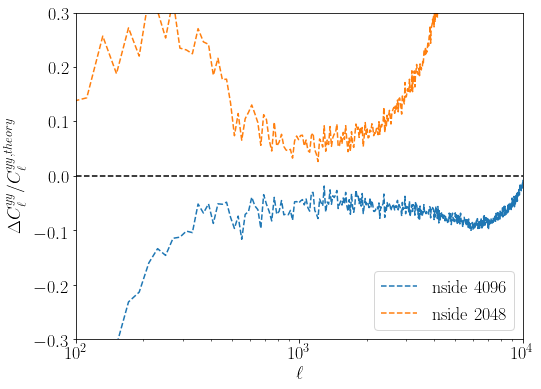

In [60]:
clyy_hp = df[:,0]
ell_hp = np.arange(len(clyy_hp))
fig, ax = plt.subplots(1,1)
fig.set_size_inches((8,6))  
# ax.errorbar(df[:,0], 1e12*(1./(2*np.pi))*(df[:,0])*(df[:,0] + 1.)*df[:,1],  label = r'$C^{yy}_{\ell} -$' + 'Theory', linestyle='--')
ax.errorbar(df[1:,0], (df[1:,1] - Cl_hp[1:])/Cl_hp[1:],  label = r'nside 4096', linestyle='--')
ax.errorbar(df2[1:,0], (df2[1:,1] - Cl_hp2[1:])/Cl_hp2[1:],  label = r'nside 2048', linestyle='--')
ax.set_xscale('log')
ax.axhline(0.0, ls ='--',color='k')
# ax.set_yscale('log')
ax.set_xlim(1e2,1e4)
ax.set_ylim(-0.3,0.3)
# ax.set_ylim(1e-3,1e1)
ax.set_ylabel(r'$\Delta C^{yy}_{\ell}/ C^{yy, theory}_{\ell}$')
ax.set_xlabel(r'$\ell$')
ax.legend()




In [64]:
import dill

df = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/y3-3x2pt-methods/cosmosis/3x2pt_pm_test/HOD_samples_data_bin' + str(3) + '_zrep_3_1percent_nbarerr_signbar_analyticmarg.pk'
dictv = dill.load(open(df,'rb'))

dictv['allp'].shape


(50000, 6)

In [65]:
np.random.randint(0, 50000)


24800